# GETTING 3 SEPARATE DF'S TO LATER COMBINE INTO 1



Overview Steps of Following Work:

1. Top 5 Short Haul Dataset: df_top5short_final
2. Top 5 Medium Haul Dataset: df_top5med_final
3. Top 5 Long Haul Dataset: df_top5long_final
4. Combined Total Dataset: df_all_final
5. Add Columns defining Short, Med, Long Haul
6. Add Pandemic features
7. Add Holiday features
8. Add Weekday/Weekend features
9. Test Colinearity
10. [IMPORTANT] Code needed to copy to be able to get the right dataset

In [1]:

#Import Packages
import snowflake.connector
import pandas as pd

# 1. TOP5 SHORT HAUL

### Distribution of Data between the years and CXR

In [2]:
##CHECKING DISTRIBUTION OF DATA BY YEAR AND CXR
    
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
     WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT <=3 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT <= 3 ORDER BY DURATION_HRSINT DESC
        )
    SELECT YEAR, CXR, COUNT(*) 
    FROM df3 
    GROUP BY YEAR , CXR
    ORDER BY max(QTS) ASC
    ;
 
    """)

    df_top5short_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


/Users/shirley/opt/anaconda3/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


KeyboardInterrupt: 

In [ ]:
df_top5short_final

### Finding Top 5 Short Haul Flights

In [ ]:
# DATA GRAIN:
#expedia
#date: June 2021-June 2022
#fare_type: Economy and ECONOMY
#departure_stops = 0
#duration_hrsint <=3
    
    #        SELECT * FROM df2 WHERE ((MONTH >= 4 AND YEAR >= 2021) OR (MONTH <= 3 AND YEAR <= 2022)) 
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
    WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT <=3 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT <= 3 ORDER BY DURATION_HRSINT DESC
        ),
    df4 as(
        SELECT * FROM df2 WHERE (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL')
    )
     SELECT MARKET,COUNT(MARKET) AS `value_occurrence` 
            FROM df4
            GROUP BY MARKET
            ORDER BY `value_occurrence` DESC
            LIMIT 5
    
    ;
    
 
    """)

    df_top5short_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [ ]:
df_top5short_final

### Final Data Grain Top 5 Short Haul Dataset

In [ ]:
# DATA GRAIN:
#expedia
#date: April 2021-March 2022
#fare_type: Economy and ECONOMY
#departure_stops =1
#duration_hrsint <=3
#Top 3 CXR: AA, UA, DW
#TOP 5 SHORT FLIGHTS
# 0	DFWORD	1644927
# 1	ORDDFW	1638829
# 2	ORDIAH	1154915
# 3	IAHORD	1125903
# 4	DFWATL	1091099
    
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
    WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT <=3 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT <= 3 ORDER BY DURATION_HRSINT DESC
        )
    SELECT * FROM df3
        WHERE 
        (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL') 
        AND  (MARKET = 'DFWORD' 
            OR MARKET = 'ORDDFW' 
            OR MARKET = 'ORDIAH' 
            OR MARKET = 'IAHORD' 
            OR MARKET = 'DFWATL')
    ;
    
 
    """)

    df_top5short_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [ ]:
df_top5short_final

# 2. TOP 5 MED HAUL

### Distribution of data by year and CXR

In [ ]:
##CHECKING DISTRIBUTION OF DATA BY YEAR and CXR
    
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
    
    
    WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 (DURATION_HRS_FLT >= 3 AND DURATION_HRS_FLT <=6)
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE (DURATION_HRSINT >= 3 AND DURATION_HRSINT <=6) ORDER BY DURATION_HRSINT DESC
        )
    SELECT YEAR, CXR, COUNT(*) 
    FROM df3 
    GROUP BY YEAR , CXR
    ORDER BY max(QTS) ASC
 
    """)

    df_top5med_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [ ]:
df_top5med_final

### Finding top5 short flights

In [ ]:
# DATA GRAIN:
#expedia
#date: June 2021-June 2022
#fare_type: Economy and ECONOMY
#departure_stops = 0
#duration_hrsint <=3
#AA, UA, DL carriers only
    
    #        SELECT * FROM df2 WHERE ((MONTH >= 4 AND YEAR >= 2021) OR (MONTH <= 3 AND YEAR <= 2022)) 
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
     WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 (DURATION_HRS_FLT >= 3 AND DURATION_HRS_FLT <=6)
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE (DURATION_HRSINT >= 3 AND DURATION_HRSINT <=6) ORDER BY DURATION_HRSINT DESC
        ),
    df4 as(
        SELECT * FROM df3 WHERE (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL')
    )
     SELECT MARKET,COUNT(MARKET) AS `value_occurrence` 
            FROM df4
            GROUP BY MARKET
            ORDER BY `value_occurrence` DESC
            LIMIT 5
    
    ;
    
 
    """)

    df_top5med_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [ ]:
df_top5med_final

### Final Data Grain of Top5 Med Haul

In [ ]:
#Splitting the departure_date into new columns of year/month
    
# 0	ATLDEN	832415
# 1	DFWLAS	500648
# 2	EWRIAH	366561
# 3	IAHEWR	348468
# 4	LAXHNL	332463
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
    WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 (DURATION_HRS_FLT >= 3 AND DURATION_HRS_FLT <=6)
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE (DURATION_HRSINT >= 3 AND DURATION_HRSINT <=6) ORDER BY DURATION_HRSINT DESC
        )
    SELECT * FROM df3
        WHERE 
        (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL') 
        AND  (MARKET = 'ATLDEN' 
            OR MARKET = 'DFWLAS' 
            OR MARKET = 'EWRIAH' 
            OR MARKET = 'IAHEWR' 
            OR MARKET = 'LAXHNL')
 
      ;
 
    """)

    df_top5med_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [ ]:
df_top5med_final

# 3. LONG HAUL

### Distribution of Data by Year and CXR

In [ ]:
##CHECKING DISTRIBUTION OF DATA BY YEAR and CXR
    
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
      WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT >=5 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT >6 ORDER BY DURATION_HRSINT DESC
        )
    SELECT YEAR, CXR, COUNT(*) 
    FROM df3 
    GROUP BY YEAR , CXR
    ORDER BY max(QTS) ASC
    ;
 
    """)

    df_top5long_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)
    
    
   


In [ ]:
df_top5long_final

Based off of this data, we are only going to be studying the top3 Carriers

### Finding Top5 Long Haul Flights

In [ ]:
# DATA GRAIN:
#expedia
#date: June 2021-June 2022
#fare_type: Economy and ECONOMY
#departure_stops = 0
#duration_hrsint <=3
#AA, UA, DL carriers only
    
    #        SELECT * FROM df2 WHERE ((MONTH >= 4 AND YEAR >= 2021) OR (MONTH <= 3 AND YEAR <= 2022)) 
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
    WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT >=5 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT >6 ORDER BY DURATION_HRSINT DESC
        ),
    df4 as(
        SELECT * FROM df3 WHERE (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL')
    )
     SELECT MARKET,COUNT(MARKET) AS `value_occurrence` 
            FROM df4
            GROUP BY MARKET
            ORDER BY `value_occurrence` DESC
            LIMIT 5
    
    ;
    
 
    """)

    df_top5long_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [ ]:
df_top5long_final

### Final Top5 Long Haul Dataset

In [ ]:
#Splitting the departure_date into new columns of year/month
# 0	EZEMIA	25349
# 1	JFKSFO	25128
# 2	MIAEZE	23597
# 3	LHRJFK	14548
# 4	MIAGRU	14450

try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
         WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT >=5 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT >6 ORDER BY DURATION_HRSINT DESC
        )
        
        SELECT * FROM df3
         WHERE 
         (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL') 
            AND  (MARKET = 'EZEMIA' 
             OR MARKET = 'JFKSFO' 
             OR MARKET = 'MIAEZE' 
             OR MARKET = 'LHRJFK' 
             OR MARKET = 'MIAGRU')

     
      ;
 
    """)

    df_top5long_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [ ]:
df_top5long_final

# 4. CREATING A NEW DATASET WITH ALL OF THE TYPES OF HAULS

### Checking the length of all the datasets

In [ ]:
len(df_top5short_final) + len(df_top5med_final) + len(df_top5long_final)

In [ ]:
len(df_top5short_final)

In [ ]:
len(df_top5med_final)

In [ ]:
len(df_top5long_final)

### Combining all three datasets into 1

In [ ]:
#Combining short, med, long haul dfs together
short_med = pd.concat([df_top5short_final, df_top5med_final], axis=0)
df_all = pd.concat([short_med, df_top5long_final], axis=0)

In [ ]:
len(df_all)

In [ ]:
df_all.head()

# 5. Adding in the short, med, long haul column features

In [ ]:
#Adding the new short, med, long haul features
df_all['SHORT_HAUL'] = df_all['DURATION_HRSINT'].apply(lambda x: 1 if x <= 3 else 0)
df_all['MED_HAUL'] = df_all['DURATION_HRSINT'].apply(lambda x: 1 if x > 3 and x <=6  else 0)
df_all['LONG_HAUL'] = df_all['DURATION_HRSINT'].apply(lambda x: 1 if x > 6 else 0)


In [ ]:
df_all.head()

# BREAK IN BETWEEN WORK, START RUNNING CODE FROM HERE!!!!

# 6. Code Needed to Copy to Get the Right Dataset

### Short Haul DF

In [2]:
# DATA GRAIN:
#expedia
#date: April 2021-March 2022
#fare_type: Economy and ECONOMY
#departure_stops =1
#duration_hrsint <=3
#Top 3 CXR: AA, UA, DW
#TOP 5 SHORT FLIGHTS
# 0	DFWORD	1644927
# 1	ORDDFW	1638829
# 2	ORDIAH	1154915
# 3	IAHORD	1125903
# 4	DFWATL	1091099
    
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
    WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT <=3 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT <= 3 ORDER BY DURATION_HRSINT DESC
        )
    SELECT * FROM df3
        WHERE 
        (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL') 
        AND  (MARKET = 'DFWORD' 
            OR MARKET = 'ORDDFW' 
            OR MARKET = 'ORDIAH' 
            OR MARKET = 'IAHORD' 
            OR MARKET = 'DFWATL')
    ;
    
 
    """)

    df_top5short_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


/Users/shirley/opt/anaconda3/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


In [3]:
df_top5short_final = df_top5short_final.dropna()

### Med Haul DF

In [4]:
#Splitting the departure_date into new columns of year/month
    
# 0	ATLDEN	832415
# 1	DFWLAS	500648
# 2	EWRIAH	366561
# 3	IAHEWR	348468
# 4	LAXHNL	332463
try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
    WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 (DURATION_HRS_FLT >= 3 AND DURATION_HRS_FLT <=6)
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE (DURATION_HRSINT >= 3 AND DURATION_HRSINT <=6) ORDER BY DURATION_HRSINT DESC
        )
    SELECT * FROM df3
        WHERE 
        (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL') 
        AND  (MARKET = 'ATLDEN' 
            OR MARKET = 'DFWLAS' 
            OR MARKET = 'EWRIAH' 
            OR MARKET = 'IAHEWR' 
            OR MARKET = 'LAXHNL')
 
      ;
 
    """)

    df_top5med_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [5]:
df_top5med_final = df_top5med_final.dropna()

### Long Haul DF

In [6]:
#Splitting the departure_date into new columns of year/month
# 0	EZEMIA	25349
# 1	JFKSFO	25128
# 2	MIAEZE	23597
# 3	LHRJFK	14548
# 4	MIAGRU	14450

try:
    ctx= snowflake.connector.connect(user='CMU',
                                     password="ql2_analytics",
                                     account="zk56677",
                                     database='QL2_PROD',
                                     schema='public',
                                     warehouse='CMU_WAREHOUSE',
                                     role='SYSADMIN' )
    cursor = ctx.cursor()
    cur = cursor.execute(""" 
         WITH df1 as(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT,
         LEFT(DURATION_FLIGHT,CHARINDEX(':',DURATION_FLIGHT)-1) AS DURATION_HRS,
         RIGHT(DURATION_FLIGHT,CHARINDEX(':', (REVERSE(DURATION_FLIGHT))) - 1) AS DURATION_MIN,
         CAST(DURATION_HRS AS FLOAT)DURATION_HRS_FLT,
         CAST(DURATION_MIN AS FLOAT)DURATION_MIN_FLT
     FROM CAPSTONE_RAW_AIRFARE_V
    
    ),
     df2 as(
         SELECT *, EXTRACT(MONTH FROM QTS) AS MONTH, EXTRACT(YEAR FROM QTS) AS YEAR 
             FROM df1 WHERE (
                 DURATION_HRS_FLT >=5 
                 AND DEPARTURE_STOPS = 0
                 AND (FARE_TYPE = 'ECONOMY'OR FARE_TYPE = 'Economy') 
          )
     ), 
     df3 AS(
    SELECT 
         MARKET, SITE, CXR, QTS, QL2_QTS, DEPARTURE_DATE, QL2_DDATE, DEPARTURE_STOPS,FARE_TYPE, FARE, 
         FLIGHT_NUMBER, DEPARTURE_TIME, ROUTE, YEAR_MONTH, DURATION_FLIGHT, MONTH, YEAR,
        CASE WHEN DURATION_MIN_FLT >= 30 
            THEN DURATION_HRS_FLT + 1 
            ELSE DURATION_HRS_FLT END AS DURATION_HRSINT
        FROM df2
        WHERE DURATION_HRSINT >6 ORDER BY DURATION_HRSINT DESC
        )
        
        SELECT * FROM df3
         WHERE 
         (CXR = 'AA' OR CXR = 'UA' OR CXR = 'DL') 
            AND  (MARKET = 'EZEMIA' 
             OR MARKET = 'JFKSFO' 
             OR MARKET = 'MIAEZE' 
             OR MARKET = 'LHRJFK' 
             OR MARKET = 'MIAGRU')

     
      ;
 
    """)

    df_top5long_final = cur.fetch_pandas_all()
    
except Exception as e:
    print("failed connecting to QL2_PROD",e)


In [7]:
df_top5long_final = df_top5long_final.dropna()

### Combining all 3 dataset

In [8]:
#Combining short, med, long haul dfs together
short_med = pd.concat([df_top5short_final, df_top5med_final], axis=0)
df_all = pd.concat([short_med, df_top5long_final], axis=0)

### Adding Column HAUL_TYPE

In [9]:
df_all['HAUL_TYPE'] = df_all['DURATION_HRSINT'].apply(lambda x: 'short'if x <= 3 else ('medium' if (x >3 and x <=6) else 'long'))


In [10]:
df_all

,MARKET,SITE,CXR,QTS,QL2_QTS,DEPARTURE_DATE,QL2_DDATE,DEPARTURE_STOPS,FARE_TYPE,FARE,FLIGHT_NUMBER,DEPARTURE_TIME,ROUTE,YEAR_MONTH,DURATION_FLIGHT,MONTH,YEAR,DURATION_HRSINT,HAUL_TYPE
0,IAHORD,EXP,AA,2021-12-26 19:08:00,7299,2022-01-13,7317,0,ECONOMY,83.40,1224,06:44,06:44 - IAH :: 09:29 - ORD,IAHORD20221,2:45,12,2021,3.0,short
1,IAHORD,EXP,AA,2022-01-03 23:08:00,7307,2022-01-19,7323,0,ECONOMY,68.60,1224,06:44,06:44 - IAH :: 09:29 - ORD,IAHORD20221,2:45,1,2022,3.0,short
2,IAHORD,EXP,UA,2022-01-03 23:08:00,7307,2022-01-19,7323,0,ECONOMY,118.60,779,12:15,12:15 - IAH :: 14:55 - ORD,IAHORD20221,2:40,1,2022,3.0,short
3,IAHORD,EXP,UA,2022-01-03 23:08:00,7307,2022-01-19,7323,0,ECONOMY,118.60,1989,16:41,16:41 - IAH :: 19:22 - ORD,IAHORD20221,2:41,1,2022,3.0,short
4,IAHORD,EXP,UA,2022-01-03 23:08:00,7307,2022-01-30,7334,0,ECONOMY,98.60,2263,20:25,20:25 - IAH :: 23:03 - ORD,IAHORD20221,2:38,1,2022,3.0,short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2906,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2021-12-16,7289,0,ECONOMY,208.41,442,11:05,11:05 - JFK :: 14:51 - SFO,JFKSFO202112,6:46,11,2021,7.0,long
2907,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2021-12-16,7289,0,ECONOMY,418.40,314,20:30,20:30 - JFK :: 00:30 - SFO,JFKSFO202112,7:0,11,2021,7.0,long
2908,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2022-02-19,7354,0,ECONOMY,208.41,311,16:10,16:10 - JFK :: 19:59 - SFO,JFKSFO20222,6:49,11,2021,7.0,long
2909,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2022-02-19,7354,0,ECONOMY,418.40,442,11:05,11:05 - JFK :: 14:43 - SFO,JFKSFO20222,6:38,11,2021,7.0,long


# 7. cleaning data

In [13]:
# casting df_all to variable a
a = df_all

In [14]:
# check uniqueness of each column
#a['CURRENCY'].unique()
#a['RDATE'].unique()

In [15]:
import time
import datetime as dt

# transforming type of DATE and QTS to datetime object
a['tDATE'] = pd.to_datetime(a['DEPARTURE_DATE'])
a['tqts'] = pd.to_datetime(a['QTS'])
# calculating time till Departure
a['re'] = a['tDATE'] - a['tqts']
a

,MARKET,SITE,CXR,QTS,QL2_QTS,DEPARTURE_DATE,QL2_DDATE,DEPARTURE_STOPS,FARE_TYPE,FARE,...,ROUTE,YEAR_MONTH,DURATION_FLIGHT,MONTH,YEAR,DURATION_HRSINT,HAUL_TYPE,tDATE,tqts,re
0,IAHORD,EXP,AA,2021-12-26 19:08:00,7299,2022-01-13,7317,0,ECONOMY,83.40,...,06:44 - IAH :: 09:29 - ORD,IAHORD20221,2:45,12,2021,3.0,short,2022-01-13,2021-12-26 19:08:00,17 days 04:52:00
1,IAHORD,EXP,AA,2022-01-03 23:08:00,7307,2022-01-19,7323,0,ECONOMY,68.60,...,06:44 - IAH :: 09:29 - ORD,IAHORD20221,2:45,1,2022,3.0,short,2022-01-19,2022-01-03 23:08:00,15 days 00:52:00
2,IAHORD,EXP,UA,2022-01-03 23:08:00,7307,2022-01-19,7323,0,ECONOMY,118.60,...,12:15 - IAH :: 14:55 - ORD,IAHORD20221,2:40,1,2022,3.0,short,2022-01-19,2022-01-03 23:08:00,15 days 00:52:00
3,IAHORD,EXP,UA,2022-01-03 23:08:00,7307,2022-01-19,7323,0,ECONOMY,118.60,...,16:41 - IAH :: 19:22 - ORD,IAHORD20221,2:41,1,2022,3.0,short,2022-01-19,2022-01-03 23:08:00,15 days 00:52:00
4,IAHORD,EXP,UA,2022-01-03 23:08:00,7307,2022-01-30,7334,0,ECONOMY,98.60,...,20:25 - IAH :: 23:03 - ORD,IAHORD20221,2:38,1,2022,3.0,short,2022-01-30,2022-01-03 23:08:00,26 days 00:52:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2906,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2021-12-16,7289,0,ECONOMY,208.41,...,11:05 - JFK :: 14:51 - SFO,JFKSFO202112,6:46,11,2021,7.0,long,2021-12-16,2021-11-04 03:34:00,41 days 20:26:00
2907,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2021-12-16,7289,0,ECONOMY,418.40,...,20:30 - JFK :: 00:30 - SFO,JFKSFO202112,7:0,11,2021,7.0,long,2021-12-16,2021-11-04 03:34:00,41 days 20:26:00
2908,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2022-02-19,7354,0,ECONOMY,208.41,...,16:10 - JFK :: 19:59 - SFO,JFKSFO20222,6:49,11,2021,7.0,long,2022-02-19,2021-11-04 03:34:00,106 days 20:26:00
2909,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2022-02-19,7354,0,ECONOMY,418.40,...,11:05 - JFK :: 14:43 - SFO,JFKSFO20222,6:38,11,2021,7.0,long,2022-02-19,2021-11-04 03:34:00,106 days 20:26:00


In [16]:
# calculate days till departure
a['DaysTillDeparture'] = a['re'].dt.components.days

/Users/shirley/opt/anaconda3/lib/python3.7/site-packages/cryptography/hazmat/backends/openssl/x509.py:17: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  utils.DeprecatedIn35,


In [17]:
a

,MARKET,SITE,CXR,QTS,QL2_QTS,DEPARTURE_DATE,QL2_DDATE,DEPARTURE_STOPS,FARE_TYPE,FARE,...,YEAR_MONTH,DURATION_FLIGHT,MONTH,YEAR,DURATION_HRSINT,HAUL_TYPE,tDATE,tqts,re,DaysTillDeparture
0,IAHORD,EXP,AA,2021-12-26 19:08:00,7299,2022-01-13,7317,0,ECONOMY,83.40,...,IAHORD20221,2:45,12,2021,3.0,short,2022-01-13,2021-12-26 19:08:00,17 days 04:52:00,17
1,IAHORD,EXP,AA,2022-01-03 23:08:00,7307,2022-01-19,7323,0,ECONOMY,68.60,...,IAHORD20221,2:45,1,2022,3.0,short,2022-01-19,2022-01-03 23:08:00,15 days 00:52:00,15
2,IAHORD,EXP,UA,2022-01-03 23:08:00,7307,2022-01-19,7323,0,ECONOMY,118.60,...,IAHORD20221,2:40,1,2022,3.0,short,2022-01-19,2022-01-03 23:08:00,15 days 00:52:00,15
3,IAHORD,EXP,UA,2022-01-03 23:08:00,7307,2022-01-19,7323,0,ECONOMY,118.60,...,IAHORD20221,2:41,1,2022,3.0,short,2022-01-19,2022-01-03 23:08:00,15 days 00:52:00,15
4,IAHORD,EXP,UA,2022-01-03 23:08:00,7307,2022-01-30,7334,0,ECONOMY,98.60,...,IAHORD20221,2:38,1,2022,3.0,short,2022-01-30,2022-01-03 23:08:00,26 days 00:52:00,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2906,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2021-12-16,7289,0,ECONOMY,208.41,...,JFKSFO202112,6:46,11,2021,7.0,long,2021-12-16,2021-11-04 03:34:00,41 days 20:26:00,41
2907,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2021-12-16,7289,0,ECONOMY,418.40,...,JFKSFO202112,7:0,11,2021,7.0,long,2021-12-16,2021-11-04 03:34:00,41 days 20:26:00,41
2908,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2022-02-19,7354,0,ECONOMY,208.41,...,JFKSFO20222,6:49,11,2021,7.0,long,2022-02-19,2021-11-04 03:34:00,106 days 20:26:00,106
2909,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2022-02-19,7354,0,ECONOMY,418.40,...,JFKSFO20222,6:38,11,2021,7.0,long,2022-02-19,2021-11-04 03:34:00,106 days 20:26:00,106


In [18]:
#fixing all of the -1 values for the DaysTillDeparture
a.loc[(a["DaysTillDeparture"] == -1), "DaysTillDeparture" ] = 0

In [19]:
# checking the first 4000 rows
pd.options.display.max_rows = 4000

In [20]:
#see the distribution of daystilldeparture values
dtd_distr = a['DaysTillDeparture'].value_counts()
df_dtd_distr = pd.DataFrame(dtd_distr)
df_dtd_distr.index.name = 'numdays_beforedep'

print(df_dtd_distr.sort_values('numdays_beforedep'))

                   DaysTillDeparture
numdays_beforedep                   
0                             543358
1                             381865
2                             350565
3                             347375
4                             348869
5                             345298
6                             344740
7                             338012
8                             338154
9                             341853
10                            340101
11                            340890
12                            344187
13                            353391
14                            345979
15                            345196
16                            346998
17                            348136
18                            347000
19                            345781
20                            344516
21                            336929
22                            335367
23                            336387
24                            336552
2

In [21]:
# defining the categories of Haul Type
# 1month = days till departure less than or equal to 30 days
# 2-4month = days till departure greater than 30 days and less than 120 days
# 4+month = days till departure greater than 12= days

a['DaysTillDeparture'] = a['DaysTillDeparture'].apply(lambda x: '1month'if x <= 30 else ('2-4month' if (x > 30 and x <=119) else '4+month'))


In [22]:
# double check
a.loc[a['DaysTillDeparture'] == "4+month"]

,MARKET,SITE,CXR,QTS,QL2_QTS,DEPARTURE_DATE,QL2_DDATE,DEPARTURE_STOPS,FARE_TYPE,FARE,...,YEAR_MONTH,DURATION_FLIGHT,MONTH,YEAR,DURATION_HRSINT,HAUL_TYPE,tDATE,tqts,re,DaysTillDeparture
19248,ORDIAH,EXP,UA,2022-03-02 04:47:00,7365,2022-07-18,7503,0,ECONOMY,358.60,...,ORDIAH20227,2:43,3,2022,3.0,short,2022-07-18,2022-03-02 04:47:00,137 days 19:13:00,4+month
19249,ORDDFW,EXP,UA,2022-03-02 04:47:00,7365,2022-07-18,7503,0,ECONOMY,318.60,...,ORDDFW20227,2:31,3,2022,3.0,short,2022-07-18,2022-03-02 04:47:00,137 days 19:13:00,4+month
19250,ORDIAH,EXP,UA,2022-03-02 04:47:00,7365,2022-07-18,7503,0,ECONOMY,438.60,...,ORDIAH20227,2:45,3,2022,3.0,short,2022-07-18,2022-03-02 04:47:00,137 days 19:13:00,4+month
17164,ORDIAH,EXP,UA,2022-04-06 03:11:00,7400,2022-08-16,7532,0,ECONOMY,244.60,...,ORDIAH20228,2:44,4,2022,3.0,short,2022-08-16,2022-04-06 03:11:00,131 days 20:49:00,4+month
17165,ORDIAH,EXP,UA,2022-04-06 03:11:00,7400,2022-08-16,7532,0,ECONOMY,308.60,...,ORDIAH20228,2:52,4,2022,3.0,short,2022-08-16,2022-04-06 03:11:00,131 days 20:49:00,4+month
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2408,JFKSFO,EXP,DL,2021-04-02 06:33:00,7031,2021-08-07,7158,0,ECONOMY,383.41,...,JFKSFO20218,7:4,4,2021,7.0,long,2021-08-07,2021-04-02 06:33:00,126 days 17:27:00,4+month
2409,JFKSFO,EXP,DL,2021-04-02 06:33:00,7031,2021-08-07,7158,0,ECONOMY,453.41,...,JFKSFO20218,7:3,4,2021,7.0,long,2021-08-07,2021-04-02 06:33:00,126 days 17:27:00,4+month
2524,JFKSFO,EXP,AA,2021-10-12 19:09:00,7224,2022-02-10,7345,0,ECONOMY,126.40,...,JFKSFO20222,6:54,10,2021,7.0,long,2022-02-10,2021-10-12 19:09:00,120 days 04:51:00,4+month
2630,JFKSFO,EXP,AA,2021-10-12 19:09:00,7224,2022-02-10,7345,0,ECONOMY,98.40,...,JFKSFO20222,6:47,10,2021,7.0,long,2022-02-10,2021-10-12 19:09:00,120 days 04:51:00,4+month


### Cleaning other variables

In [27]:
# cast all string entry in FARE_TYPE column to lower case
a['FARE_TYPE'] = a['FARE_TYPE'].apply(lambda x: str.lower(x))

In [28]:
# clean the data/type of DURATION

# first convert to string
def convert_to_string (x):
    string = str(x).split('\n')[0].split(' ')[-1] + ':00'
    return string
a['DURATION_FLIGHT'] = a['DURATION_FLIGHT'].apply(convert_to_string)
a['DURATION_FLIGHT']

0       2:45:00
1       2:45:00
2       2:40:00
3       2:41:00
4       2:38:00
         ...   
2906    6:46:00
2907     7:0:00
2908    6:49:00
2909    6:38:00
2910     7:0:00
Name: DURATION_FLIGHT, Length: 11083373, dtype: object

In [29]:
# convert DURATION from string to timedelta object
#a['DURATION_FLIGHT']= pd.to_timedelta(a['DURATION_FLIGHT'])
#a['DURATION_FLIGHT']

In [30]:
#timedelta.round(freq='H')

In [31]:
# convert DURATION from timedelta object to total seconds in float type
#a['DURATION_FLIGHT'] = a['DURATION_FLIGHT'].apply(lambda x: x.total_seconds())
#a['DURATION_FLIGHT']

In [32]:
a

,MARKET,SITE,CXR,QTS,QL2_QTS,DEPARTURE_DATE,QL2_DDATE,DEPARTURE_STOPS,FARE_TYPE,FARE,...,YEAR_MONTH,DURATION_FLIGHT,MONTH,YEAR,DURATION_HRSINT,HAUL_TYPE,tDATE,tqts,re,DaysTillDeparture
0,IAHORD,EXP,AA,2021-12-26 19:08:00,7299,2022-01-13,7317,0,economy,83.40,...,IAHORD20221,2:45:00,12,2021,3.0,short,2022-01-13,2021-12-26 19:08:00,17 days 04:52:00,1month
1,IAHORD,EXP,AA,2022-01-03 23:08:00,7307,2022-01-19,7323,0,economy,68.60,...,IAHORD20221,2:45:00,1,2022,3.0,short,2022-01-19,2022-01-03 23:08:00,15 days 00:52:00,1month
2,IAHORD,EXP,UA,2022-01-03 23:08:00,7307,2022-01-19,7323,0,economy,118.60,...,IAHORD20221,2:40:00,1,2022,3.0,short,2022-01-19,2022-01-03 23:08:00,15 days 00:52:00,1month
3,IAHORD,EXP,UA,2022-01-03 23:08:00,7307,2022-01-19,7323,0,economy,118.60,...,IAHORD20221,2:41:00,1,2022,3.0,short,2022-01-19,2022-01-03 23:08:00,15 days 00:52:00,1month
4,IAHORD,EXP,UA,2022-01-03 23:08:00,7307,2022-01-30,7334,0,economy,98.60,...,IAHORD20221,2:38:00,1,2022,3.0,short,2022-01-30,2022-01-03 23:08:00,26 days 00:52:00,1month
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2906,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2021-12-16,7289,0,economy,208.41,...,JFKSFO202112,6:46:00,11,2021,7.0,long,2021-12-16,2021-11-04 03:34:00,41 days 20:26:00,2-4month
2907,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2021-12-16,7289,0,economy,418.40,...,JFKSFO202112,7:0:00,11,2021,7.0,long,2021-12-16,2021-11-04 03:34:00,41 days 20:26:00,2-4month
2908,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2022-02-19,7354,0,economy,208.41,...,JFKSFO20222,6:49:00,11,2021,7.0,long,2022-02-19,2021-11-04 03:34:00,106 days 20:26:00,2-4month
2909,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2022-02-19,7354,0,economy,418.40,...,JFKSFO20222,6:38:00,11,2021,7.0,long,2022-02-19,2021-11-04 03:34:00,106 days 20:26:00,2-4month


# 8. Adding the Column Features for Pre-pandemic/Post-pandemic as 0/1</h3>

In [33]:
import datetime as dt

In [34]:
# # adding pandemic features
b = a

# # 0: pre-pandemic, 1: post-pandemic
b['Pandemic'] = (df_all['DEPARTURE_DATE'] > dt.date(2020,3,20)).apply(lambda x: int(x))

# 9. Adding holiday features as 1/0</h3>

In [35]:
# uncomment pip install line below if holidays packages has not been downloaded
#pip install holidays
import holidays

In [36]:
# get holidays of US
us_holidays = holidays.UnitedStates()

In [37]:
# adding holiday features

## check if a date is a US holiday
def checkHoliday(date):
    holiday_name = us_holidays.get(date.strftime("%m-%d-%Y"))
    if holiday_name != None:
        return int(1)
    else:
        return int(0)

# for Holidays column, 1 indicates it is a holiday, and 0 indicates it is a non-holiday
b['Holidays'] = b['DEPARTURE_DATE'].apply(lambda x: checkHoliday(x))

# 10. Adding Weekday/Weekend Feature as 1/0

In [38]:
# return 1 for weekday, 0 for weekend
def checkWeekdays(date):
    dayOfWeek = date.weekday()
    return int(dayOfWeek < 5)
b['Weekday'] = b['DEPARTURE_DATE'].apply(lambda x: checkWeekdays(x))

b[b.DEPARTURE_DATE == dt.date(2021,12,25)].head()

,MARKET,SITE,CXR,QTS,QL2_QTS,DEPARTURE_DATE,QL2_DDATE,DEPARTURE_STOPS,FARE_TYPE,FARE,...,YEAR,DURATION_HRSINT,HAUL_TYPE,tDATE,tqts,re,DaysTillDeparture,Pandemic,Holidays,Weekday
144,IAHORD,EXP,UA,2021-12-08 13:08:00,7281,2021-12-25,7298,0,economy,120.4,...,2021,3.0,short,2021-12-25,2021-12-08 13:08:00,16 days 10:52:00,1month,1,1,0
145,IAHORD,EXP,UA,2021-12-08 13:08:00,7281,2021-12-25,7298,0,economy,120.4,...,2021,3.0,short,2021-12-25,2021-12-08 13:08:00,16 days 10:52:00,1month,1,1,0
146,IAHORD,EXP,UA,2021-12-08 13:08:00,7281,2021-12-25,7298,0,economy,120.4,...,2021,3.0,short,2021-12-25,2021-12-08 13:08:00,16 days 10:52:00,1month,1,1,0
171,ORDDFW,EXP,UA,2021-12-07 22:09:00,7280,2021-12-25,7298,0,economy,278.4,...,2021,3.0,short,2021-12-25,2021-12-07 22:09:00,17 days 01:51:00,1month,1,1,0
172,ORDDFW,EXP,UA,2021-12-07 22:09:00,7280,2021-12-25,7298,0,economy,278.4,...,2021,3.0,short,2021-12-25,2021-12-07 22:09:00,17 days 01:51:00,1month,1,1,0


# 10a. Train/Test Split

In [39]:
# dropping missing values
c = b.dropna()

In [40]:
# show all columns and check dataframe
pd.set_option('display.max_columns', None)
c

,MARKET,SITE,CXR,QTS,QL2_QTS,DEPARTURE_DATE,QL2_DDATE,DEPARTURE_STOPS,FARE_TYPE,FARE,FLIGHT_NUMBER,DEPARTURE_TIME,ROUTE,YEAR_MONTH,DURATION_FLIGHT,MONTH,YEAR,DURATION_HRSINT,HAUL_TYPE,tDATE,tqts,re,DaysTillDeparture,Pandemic,Holidays,Weekday
0,IAHORD,EXP,AA,2021-12-26 19:08:00,7299,2022-01-13,7317,0,economy,83.40,1224,06:44,06:44 - IAH :: 09:29 - ORD,IAHORD20221,2:45:00,12,2021,3.0,short,2022-01-13,2021-12-26 19:08:00,17 days 04:52:00,1month,1,0,1
1,IAHORD,EXP,AA,2022-01-03 23:08:00,7307,2022-01-19,7323,0,economy,68.60,1224,06:44,06:44 - IAH :: 09:29 - ORD,IAHORD20221,2:45:00,1,2022,3.0,short,2022-01-19,2022-01-03 23:08:00,15 days 00:52:00,1month,1,0,1
2,IAHORD,EXP,UA,2022-01-03 23:08:00,7307,2022-01-19,7323,0,economy,118.60,779,12:15,12:15 - IAH :: 14:55 - ORD,IAHORD20221,2:40:00,1,2022,3.0,short,2022-01-19,2022-01-03 23:08:00,15 days 00:52:00,1month,1,0,1
3,IAHORD,EXP,UA,2022-01-03 23:08:00,7307,2022-01-19,7323,0,economy,118.60,1989,16:41,16:41 - IAH :: 19:22 - ORD,IAHORD20221,2:41:00,1,2022,3.0,short,2022-01-19,2022-01-03 23:08:00,15 days 00:52:00,1month,1,0,1
4,IAHORD,EXP,UA,2022-01-03 23:08:00,7307,2022-01-30,7334,0,economy,98.60,2263,20:25,20:25 - IAH :: 23:03 - ORD,IAHORD20221,2:38:00,1,2022,3.0,short,2022-01-30,2022-01-03 23:08:00,26 days 00:52:00,1month,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2906,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2021-12-16,7289,0,economy,208.41,442,11:05,11:05 - JFK :: 14:51 - SFO,JFKSFO202112,6:46:00,11,2021,7.0,long,2021-12-16,2021-11-04 03:34:00,41 days 20:26:00,2-4month,1,0,1
2907,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2021-12-16,7289,0,economy,418.40,314,20:30,20:30 - JFK :: 00:30 - SFO,JFKSFO202112,7:0:00,11,2021,7.0,long,2021-12-16,2021-11-04 03:34:00,41 days 20:26:00,2-4month,1,0,1
2908,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2022-02-19,7354,0,economy,208.41,311,16:10,16:10 - JFK :: 19:59 - SFO,JFKSFO20222,6:49:00,11,2021,7.0,long,2022-02-19,2021-11-04 03:34:00,106 days 20:26:00,2-4month,1,0,0
2909,JFKSFO,EXP,DL,2021-11-04 03:34:00,7247,2022-02-19,7354,0,economy,418.40,442,11:05,11:05 - JFK :: 14:43 - SFO,JFKSFO20222,6:38:00,11,2021,7.0,long,2022-02-19,2021-11-04 03:34:00,106 days 20:26:00,2-4month,1,0,0


In [41]:
from sklearn.linear_model import LinearRegression
# create dataframe X for input variables

# drop FARE because it's response variable
# drop SITE, CURRENCY because they only have 1 single value throughout df, so they are not helpful
# drop QTS because we have tqts
# drop 'DEPARTURE_STOPS' because we already have data grain defined as direct flights
# drop Pandemic because it's all data after pandemic
# drop CXR because we are only focusing on the prices of flights, not dependent on carrier
X = c[[ 'Pandemic','HAUL_TYPE','DaysTillDeparture', 'Holidays', 'Weekday']]
X

,Pandemic,HAUL_TYPE,DaysTillDeparture,Holidays,Weekday
0,1,short,1month,0,1
1,1,short,1month,0,1
2,1,short,1month,0,1
3,1,short,1month,0,1
4,1,short,1month,0,0
...,...,...,...,...,...
2906,1,long,2-4month,0,1
2907,1,long,2-4month,0,1
2908,1,long,2-4month,0,0
2909,1,long,2-4month,0,0


In [42]:
# create dataframe y for response variable
y = c['FARE']
y

0        83.40
1        68.60
2       118.60
3       118.60
4        98.60
         ...  
2906    208.41
2907    418.40
2908    208.41
2909    418.40
2910    168.41
Name: FARE, Length: 11083373, dtype: float64

In [43]:
# convert categorical variables in X to dummy variables
# drop_first = True because we are dropping 1 level in each category to avoid dummy variable trap.
X = pd.get_dummies(X, columns=['DaysTillDeparture', 'HAUL_TYPE',], drop_first=True)
X

,Pandemic,Holidays,Weekday,DaysTillDeparture_2-4month,DaysTillDeparture_4+month,HAUL_TYPE_medium,HAUL_TYPE_short
0,1,0,1,0,0,0,1
1,1,0,1,0,0,0,1
2,1,0,1,0,0,0,1
3,1,0,1,0,0,0,1
4,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...
2906,1,0,1,1,0,0,0
2907,1,0,1,1,0,0,0
2908,1,0,0,1,0,0,0
2909,1,0,0,1,0,0,0


In [44]:
# train test split
from sklearn.model_selection import train_test_split
x_train, x_test,y_train,y_test = train_test_split(X,y,test_size =0.2)
# print the data to double check
x_train

,Pandemic,Holidays,Weekday,DaysTillDeparture_2-4month,DaysTillDeparture_4+month,HAUL_TYPE_medium,HAUL_TYPE_short
348351,1,0,1,0,0,0,1
58280,1,0,0,0,0,0,1
116067,1,0,1,0,0,0,1
127885,1,0,1,0,0,1,0
12947,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...
40129,1,0,1,0,0,0,1
109294,1,0,0,1,0,1,0
951,1,0,1,0,0,0,1
28700,1,1,1,0,0,0,1


# 11. Implementing Linear Regression

###  11a. statistical analysis of feeding all data for linear regression (adjusted R2, confidence interval)

In [46]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [47]:
# basic linear regression with intercept
mod = smf.ols(formula='FARE ~ 1+  C(HAUL_TYPE) + C(DaysTillDeparture) + Pandemic + Holidays + Weekday', data=c)

In [48]:
#remove pandemic if needed
#mod = smf.ols(formula='FARE ~ 1+  C(HAUL_TYPE) + C(DaysTillDeparture)  + Holidays + Weekday', data=c)

In [49]:
# fitting model
res = mod.fit()

In [50]:
# output the result
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   FARE   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                 1.625e+06
Date:                Fri, 29 Apr 2022   Prob (F-statistic):               0.00
Time:                        12:36:04   Log-Likelihood:            -7.1150e+07
No. Observations:            11083373   AIC:                         1.423e+08
Df Residuals:                11083365   BIC:                         1.423e+08
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

### Based on the summary above, all factors in our model has statistically significant p-value(<0.05) to be considered to have relation with the response variable. They include HAUL_TYPE, DaysTillDeparture, Holidays, and Weekday.

### Adjusted r_square is around 0.506, which means around 50.6% of variability is explained by this linear regression model.

### plotting out confidence internal

In [58]:
# a whole method of plotting out the coefficients' confidence intervals
# input: results = summary of linear regression model

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    #coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])
    
    print(coef_df)
    
    
    ## categorizing to make the plot cleaner
    #coef_df = coef_df[3:5]
    

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='steelblue')
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

0                                         coef       std err         t  P>|t|  \
                                                                                
Pandemic                         -3.136000e+11  3.660000e+11    -0.856  0.392   
C(HAUL_TYPE)[T.short]            -1.385619e+03  4.550000e-01 -3048.388  0.000   
C(HAUL_TYPE)[T.medium]           -1.299751e+03  4.590000e-01 -2831.623  0.000   
Weekday                          -3.201220e+01  9.800000e-02  -325.376  0.000   
C(DaysTillDeparture)[T.2-4month] -3.187990e+01  2.700000e-01  -117.965  0.000   
Holidays                          2.450790e+01  2.310000e-01   105.961  0.000   
C(DaysTillDeparture)[T.4+month]   1.493024e+02  9.710000e-01   153.824  0.000   
Intercept                         3.136000e+11  3.660000e+11     0.856  0.392   

0                                       [0.025        0.975]        errors  
                                                                            
Pandemic                         -1

/Users/shirley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


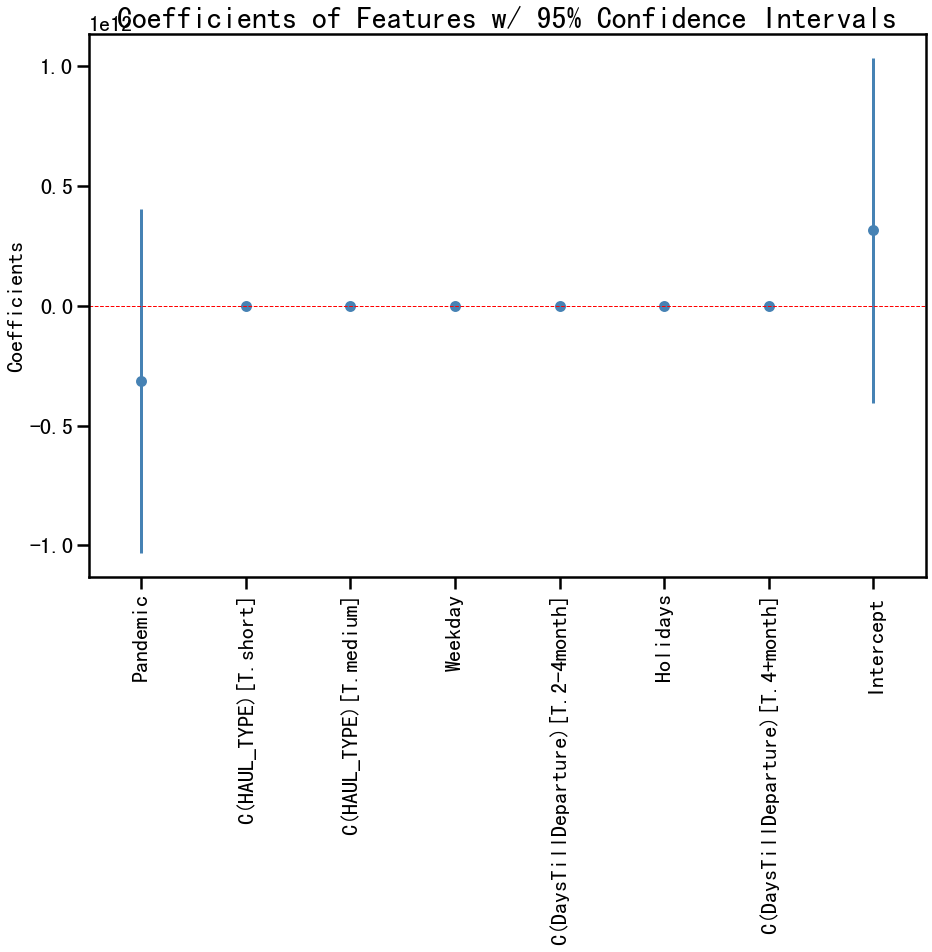

In [59]:
coefplot(res)

In [60]:
# a whole method of plotting out some of the coefficients' confidence interval, not all of them
# selecting which intervals of results to plot from index_start to index_end
# inputs: 
#    results(the summary result of linear regression)
#    index_start(starting index of coefficient in result table),
#    index_end(ending index of coefficient in result table + 1),

def coefplot_partial(results, index_start, index_end):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    
    Removes intercept, so if uncentered will return error.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    #coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])
    
    
    ## categorizing to make the plot cleaner
    coef_df = coef_df[index_start:index_end]

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables
    
    # Set sns plot style back to 'poster'
    # This will make bars wide on plot
    sns.set_context("poster")

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Error bars for 95% confidence interval
    # Can increase capsize to add whiskers
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=22, 
                 ecolor='steelblue',capsize=0,
                 yerr='errors', legend=False)
    
    # Set title & labels
    plt.title('Coefficients of Features w/ 95% Confidence Intervals',fontsize=30)
    ax.set_ylabel('Coefficients',fontsize=22)
    ax.set_xlabel('',fontsize=22)
    
    # Coefficients
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='o', s=80, 
               y=coef_df['coef'], color='steelblue')
    
    #ax.set_ylim(-120,-110)
    
    # Line to define zero on the y-axis
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1)
    
    return plt.show()

/Users/shirley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


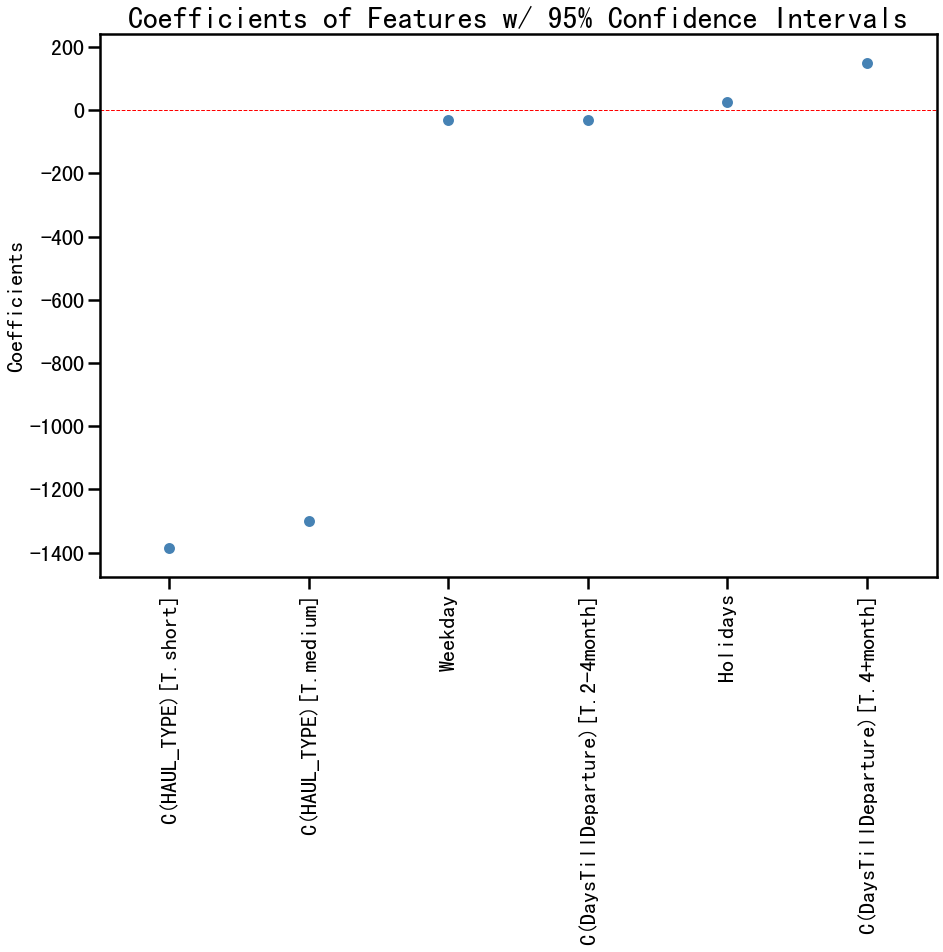

In [61]:
coefplot_partial(res, 1, 7)

In [62]:
# test of printing coefficient intervals from index 12-13
#coefplot_partial(res, 12, 14)

# 12. Testing Colinearity

In [68]:
# rebuild the dataframe X of input variables
# this time drop_first = False because we want to showcase all levels of categories in each categorical variable
# interaction between every pair of categories

X = c[[ 'Pandemic','HAUL_TYPE','DaysTillDeparture', 'Holidays', 'Weekday']]
X = pd.get_dummies(X, columns=['DaysTillDeparture', 'HAUL_TYPE',],drop_first = False)
X

# train test split
from sklearn.model_selection import train_test_split
x_train, x_test,y_train,y_test = train_test_split(X,y,test_size =0.2)
# print the data
x_train

,Pandemic,Holidays,Weekday,DaysTillDeparture_1month,DaysTillDeparture_2-4month,DaysTillDeparture_4+month,HAUL_TYPE_long,HAUL_TYPE_medium,HAUL_TYPE_short
25799,1,0,1,1,0,0,0,0,1
129737,1,0,0,1,0,0,0,1,0
6072,1,1,0,1,0,0,0,0,1
389969,1,0,1,1,0,0,0,0,1
106281,1,0,1,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
180197,1,0,1,1,0,0,0,0,1
283174,1,0,1,1,0,0,0,0,1
195299,1,0,0,1,0,0,0,0,1
55093,1,0,1,1,0,0,0,0,1


In [69]:
import seaborn as sns

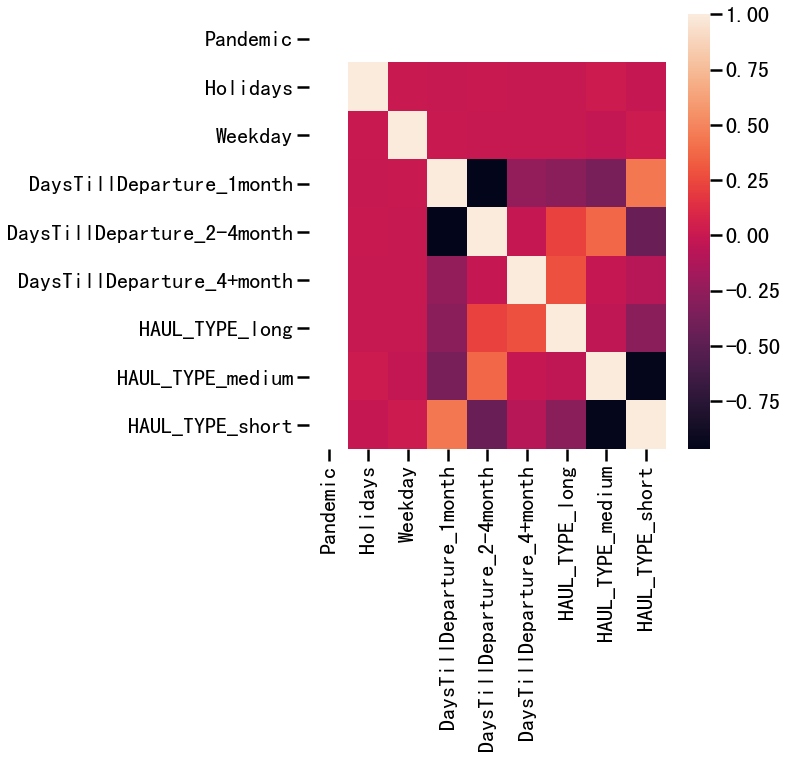

In [75]:
# shows the heatmap of correlations between factors
plt.figure(figsize=(8,8))
sns.heatmap(x_train.corr())

In [1]:
# basic heatmap of specific numerical values, not useful in this case
# sns.heatmap(x_train)

In [71]:
# shows the correlation between factors using pearson correlation
x_train.corr(method='pearson')

,Pandemic,Holidays,Weekday,DaysTillDeparture_1month,DaysTillDeparture_2-4month,DaysTillDeparture_4+month,HAUL_TYPE_long,HAUL_TYPE_medium,HAUL_TYPE_short
Pandemic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Holidays,NaN,1.000000,0.006237,-0.000908,0.001418,-0.001851,-0.005261,0.016859,-0.014466
Weekday,NaN,0.006237,1.000000,0.002486,-0.002117,-0.001711,-0.004246,-0.022956,0.023383
DaysTillDeparture_1month,NaN,-0.000908,0.002486,1.000000,-0.967555,-0.243666,-0.290720,-0.361815,0.440846
DaysTillDeparture_2-4month,NaN,0.001418,-0.002117,-0.967555,1.000000,-0.009286,0.225694,0.376412,-0.433837
DaysTillDeparture_4+month,NaN,-0.001851,-0.001711,-0.243666,-0.009286,1.000000,0.284239,-0.012933,-0.079419
HAUL_TYPE_long,NaN,-0.005261,-0.004246,-0.290720,0.225694,0.284239,1.000000,-0.038385,-0.286234
HAUL_TYPE_medium,NaN,0.016859,-0.022956,-0.361815,0.376412,-0.012933,-0.038385,1.000000,-0.946467
HAUL_TYPE_short,NaN,-0.014466,0.023383,0.440846,-0.433837,-0.079419,-0.286234,-0.946467,1.000000


# 13. Add Interaction Factors

In [67]:
# redefine linear regression model by adding interaction factor of (DaysTillDeparture*HaulType)
mod = smf.ols(formula='FARE ~ 1+  C(HAUL_TYPE) + C(DaysTillDeparture) + Pandemic + Holidays + Weekday + C(DaysTillDeparture)*C(HAUL_TYPE)', data=c)

In [68]:
# refit the linear regression model with interaction terms
res = mod.fit()

In [69]:
# print linear regression summary
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   FARE   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                 1.019e+06
Date:                Tue, 26 Apr 2022   Prob (F-statistic):               0.00
Time:                        22:57:25   Log-Likelihood:            -7.0057e+07
No. Observations:            10912809   AIC:                         1.401e+08
Df Residuals:                10912797   BIC:                         1.401e+08
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [2]:
# printing coefficient confidence interval plot of all coefficients
# coefplot(res)

/Users/shirley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


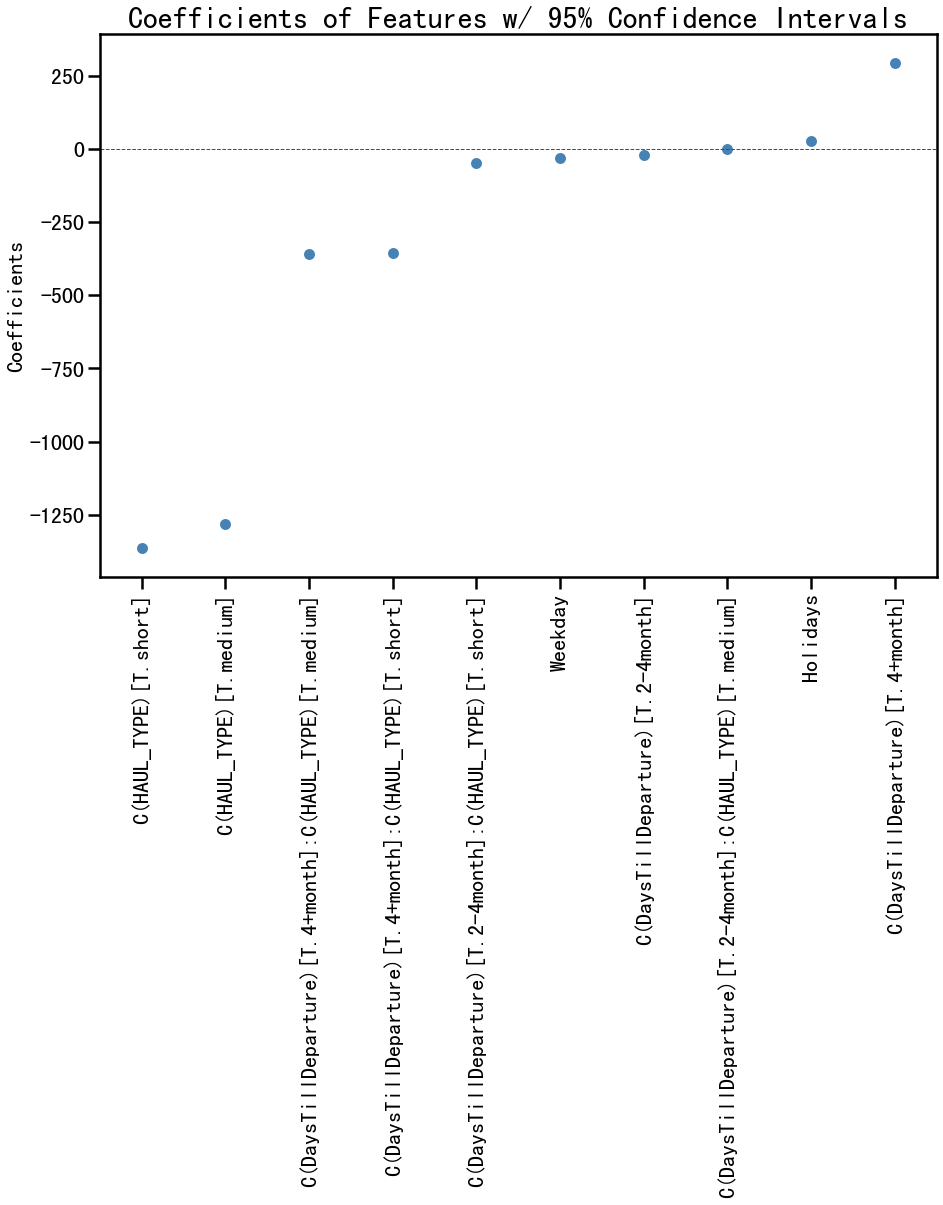

In [72]:
# printint coefficient confidence interval plot of selected coefficients from index 1-10
coefplot_partial(res, 1, 11)

# 14. Using training subset to train linear regression and get score on test set as baseline

###  14a. statistical analysis of feeding all data for linear regression (adjusted R2, confidence interval)

In [73]:
# train linear regression on training set
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [74]:
# get intercept
clf.intercept_

1629.2745558325203

In [75]:
# get coefficients
clf.coef_

array([    0.        ,    25.32393003,   -32.5719502 ,   -32.67952164,
         150.54040244, -1300.97214138, -1387.23916444])

In [76]:
# predict on test set
clf.predict(x_test)

array([209.4634412 , 209.4634412 , 209.4634412 , ..., 242.03539139,
       321.05439429, 209.4634412 ])

In [77]:
# get testing accuracy
clf.score(x_test,y_test)

0.5034685095058617

In [78]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred = clf.predict(x_test)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))

Mean squared error: 22052.32


# 15. Implementing elastic net

In [79]:
# import model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import ElasticNet
import numpy as np

In [80]:
# Train the model
e_net = ElasticNet(alpha = 1)
e_net.fit(x_train, y_train)

# getting coefficients 
e_net_coeff = pd.DataFrame()
e_net_coeff["Columns"] = x_train.columns
e_net_coeff['Coefficient Estimate'] = pd.Series(e_net.coef_)
e_net_coeff

,Columns,Coefficient Estimate
0,Pandemic,0.000000
1,Holidays,0.630417
2,Weekday,-9.395035
3,DaysTillDeparture_2-4month,10.222437
4,DaysTillDeparture_4+month,3.542499
5,HAUL_TYPE_medium,3.503232
6,HAUL_TYPE_short,-34.040612


In [81]:
# calculate the prediction and mean square error
y_pred_elastic = e_net.predict(x_test)
mean_squared_error = np.mean((y_pred_elastic - y_test)**2)
print("MSE equals", mean_squared_error)

MSE equals 42790.148708751956


In [82]:
# calculating r_square
u = ((y_test - y_pred_elastic)** 2).sum()
v = ((y_test - y_test.mean()) ** 2).sum()
r2 = 1 - u/v
r2

0.03653423192537597

In [83]:
# calculate adjusted r_square
1 - (1-e_net.score(x_train, y_train))*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)

0.03647497171229053

# 16. Implementing polynomial regression

###  16a. statistical analysis of feeding all data for polynomial regression (adjusted R2, confidence interval)
### This model has been commented due to enormous time to run, but the code is correctly written.

In [84]:
# from sklearn.preprocessing import PolynomialFeatures
# # transforming features to polynomials
# poly_reg = PolynomialFeatures(degree=4)
# X_poly = poly_reg.fit_transform(X)
# pol_reg = LinearRegression()

# # train test split
# from sklearn.model_selection import train_test_split
# x_train, x_test,y_train,y_test = train_test_split(X_poly,y,test_size =0.2)
# # print the data
# x_train

# # fitting model on training set
# pol_reg.fit(x_train, y_train)

In [85]:
# # Visualizing the Polymonial Regression results
# def viz_polymonial():
#     plt.scatter(X, y, color='red')
#     plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='blue')
#     plt.title('Truth or Bluff (Linear Regression)')
#     plt.xlabel('Position level')
#     plt.ylabel('Salary')
#     plt.show()
#     return
# #viz_polymonial()

In [86]:
# y_pred_poly = poly_reg.predict(x_test)
# y_pred_poly

In [87]:
# mean_squared_error = np.mean((y_pred_poly - y_test)**2)
# print("Mean Squared Error on test set", mean_squared_error)

In [88]:
# test_score = r2_score(y_test, y_pred_poly)
# r2 = test_score

In [89]:
# print("adjusted r_square is")
# print(1-(1-r2)*((len(x_test)-1)/(len(x_test)-len(x_test[0])-1)))

# 17. Implementing random forest

In [90]:
# redefine dataframe X of input variables as it needs every level within each category
# the default drop_first = False here means we don't drop any level

X = c[[ 'Pandemic','HAUL_TYPE','DaysTillDeparture', 'Holidays', 'Weekday']]
X = pd.get_dummies(X, columns=['DaysTillDeparture', 'HAUL_TYPE',])
X

# train test split
from sklearn.model_selection import train_test_split
x_train, x_test,y_train,y_test = train_test_split(X,y,test_size =0.2)
# print the data
x_train

,Pandemic,Holidays,Weekday,DaysTillDeparture_1month,DaysTillDeparture_2-4month,DaysTillDeparture_4+month,HAUL_TYPE_long,HAUL_TYPE_medium,HAUL_TYPE_short
149990,1,0,1,1,0,0,0,0,1
112837,1,0,1,1,0,0,0,0,1
166433,1,0,0,1,0,0,0,0,1
349163,1,0,0,1,0,0,0,0,1
77755,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...
147275,1,0,1,1,0,0,0,0,1
18440,1,0,0,1,0,0,0,0,1
4954,1,0,1,1,0,0,0,0,1
23881,1,0,0,1,0,0,0,0,1


In [91]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 10 decision trees
rf = RandomForestRegressor(n_estimators = 10, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [93]:
# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
# Print out the root sqaure of mean absolute error (mae)
print('RMSE equals:', np.sqrt(np.mean((predictions-y_test)**2)))

RMSE equals: 148.44196778177997


In [94]:
feature_name_list = np.array(x_train.columns)
feature_name_list

array(['Pandemic', 'Holidays', 'Weekday', 'DaysTillDeparture_1month',
       'DaysTillDeparture_2-4month', 'DaysTillDeparture_4+month',
       'HAUL_TYPE_long', 'HAUL_TYPE_medium', 'HAUL_TYPE_short'],
      dtype=object)

In [95]:
# plotting the variable importance of random forest

In [96]:
# setting parameters of figures and font size
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 18})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

Text(0.5, 0, 'Random Forest Feature Importance')

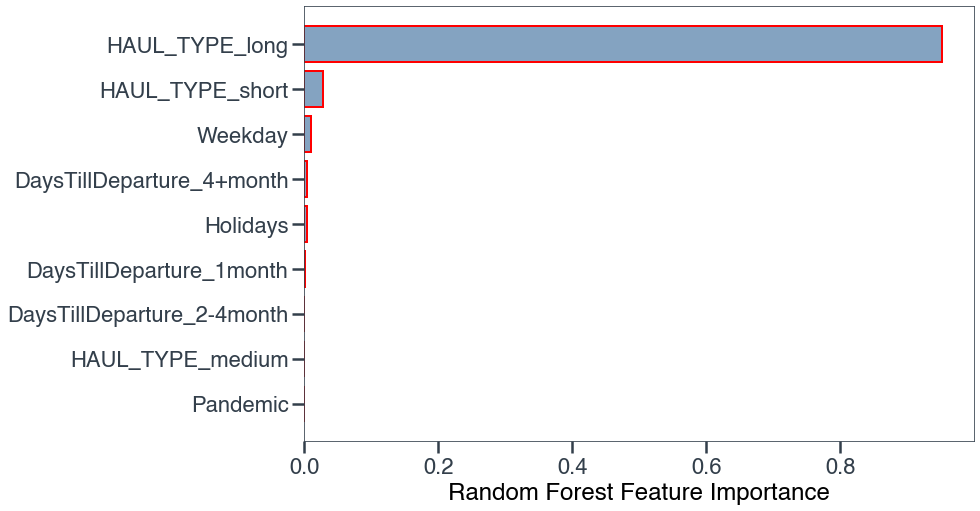

In [97]:
# variable importance plot
sorted_idx = rf.feature_importances_.argsort()
plt.barh(feature_name_list[sorted_idx], rf.feature_importances_[sorted_idx],color=(0.2, 0.4, 0.6, 0.6), edgecolor = 'red')
plt.xlabel("Random Forest Feature Importance")

In [98]:
# pip install --upgrade xgboost

# 18. Implementing XGBoost

In [99]:
# install xgboost package with the following
# brew install libomp
# pip install xgboost==1.1.0
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

In [100]:
xgb_df = c[['FARE','Pandemic','HAUL_TYPE','DaysTillDeparture', 'Holidays', 'Weekday']]
xgb_df = pd.get_dummies(xgb_df, columns=['HAUL_TYPE', 'DaysTillDeparture'],drop_first=False)
xgb_df

,FARE,Pandemic,Holidays,Weekday,HAUL_TYPE_long,HAUL_TYPE_medium,HAUL_TYPE_short,DaysTillDeparture_1month,DaysTillDeparture_2-4month,DaysTillDeparture_4+month
0,205.6,1,0,0,0,0,1,1,0,0
1,138.6,1,0,0,0,0,1,1,0,0
2,205.6,1,0,0,0,0,1,1,0,0
3,205.6,1,0,1,0,0,1,1,0,0
4,308.6,1,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...
3974,116.4,1,0,1,1,0,0,0,1,0
3975,76.4,1,0,1,1,0,0,1,0,0
3976,88.4,1,0,1,1,0,0,1,0,0
3977,101.4,1,0,1,1,0,0,1,0,0


In [101]:
# Separate the target variable and rest of the variables using .iloc to subset the data.
X_xgb, y_xgb = xgb_df.iloc[:,1:], xgb_df.iloc[:,0]

,Pandemic,Holidays,Weekday,HAUL_TYPE_long,HAUL_TYPE_medium,HAUL_TYPE_short,DaysTillDeparture_1month,DaysTillDeparture_2-4month,DaysTillDeparture_4+month
0,1,0,0,0,0,1,1,0,0
1,1,0,0,0,0,1,1,0,0
2,1,0,0,0,0,1,1,0,0
3,1,0,1,0,0,1,1,0,0
4,1,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...
3974,1,0,1,1,0,0,0,1,0
3975,1,0,1,1,0,0,1,0,0
3976,1,0,1,1,0,0,1,0,0
3977,1,0,1,1,0,0,1,0,0


In [103]:
# convert the dataset into an optimized data structure that XGBoost supports
# gives it acclaimed performance and efficiency gains
xgb_dmatrix = xgb.DMatrix(data=X_xgb,label=y_xgb)

In [104]:
# test best RMSE possible with cv: 10-fold
params={'objective':'reg:squarederror'}
cv_results = xgb.cv(dtrain=xgb_dmatrix, params=params, nfold=10, metrics={'rmse'}, as_pandas=True, seed=20)
print('RMSE: %.2f' % cv_results['test-rmse-mean'].min())

RMSE: 148.51


### Cross Validation Test for Parameter Tuning

In [105]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [106]:
X_cv_train, X_cv_test, y_cv_train, y_cv_test = train_test_split(X_xgb, y_xgb, test_size=0.1, random_state=333)

In [107]:
# Uncomment if tuning the parameters, will take pretty long time
# parameter-tuning with cross validation
# params = { 'min_child_weight':[5,7,9],
#            'max_depth':[3,5,7]}
# xgbr = xgb.XGBRegressor(seed = 20)
# clf = RandomizedSearchCV(estimator=xgbr, 
#                    param_distributions=params,
#                    scoring='neg_mean_squared_error', 
#                    verbose=1,
#                    n_iter=9)
# clf.fit(X_cv_test, y_cv_test)
# print("Best parameters:", clf.best_params_)
# print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

### Train-Test Split

In [108]:
# create the train and test set for cross-validation of the results
X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(X_xgb, y_xgb, test_size=0.2, random_state=123)

In [109]:
# instantiate an XGBoost regressor object
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, n_estimators = 500)
#xgb_reg = xgb.XGBClassifier(n_estimators = 50)

### Importance Level of Factors

In [110]:
# fit the model with data
xgb_reg.fit(X_xgb_train,y_xgb_train)

# make predictions
xgb_preds = xgb_reg.predict(X_xgb_test)

Text(0.5, 0, 'XGBoost Feature Importance')

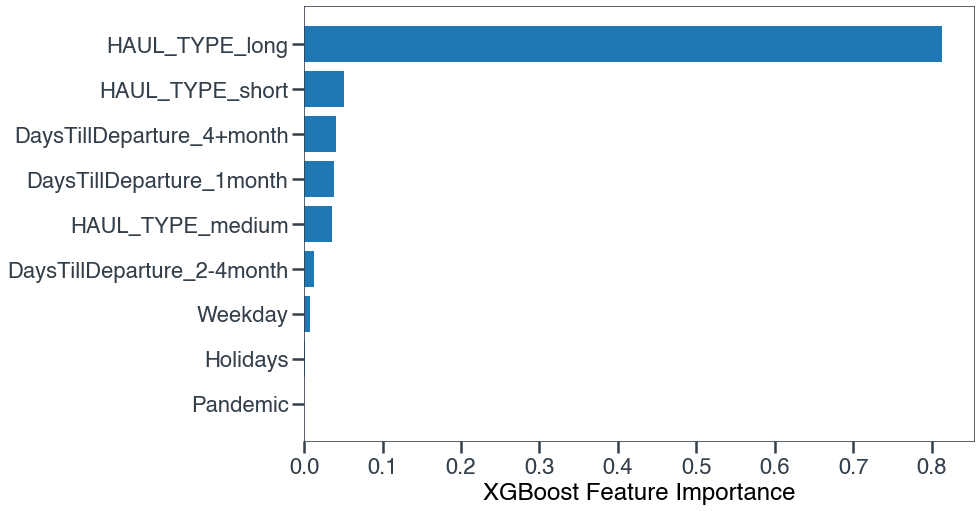

In [114]:
# Plot feature importance score
from matplotlib import pyplot as plt
plt.barh(np.array(xgb_dmatrix.feature_names)[sorted_idx], xgb_reg.feature_importances_[sorted_idx])
# setting parameters of figures and font size
plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 5})
plt.xlabel("XGBoost Feature Importance")

In [115]:
# Calculate RMSE
rmse = mean_squared_error(y_xgb_test, xgb_preds)**0.5
print("RMSE: %f" % (rmse))

RMSE: 148.391139
